In [2]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from generation.train.autoencoder import AutoEncoder, run_train, generate_new_signal
from generation.data.data_simulation import Nakagami
from generation.data.dataset_pytorch import SignalsDataset

In [3]:
# Data params
SAMPLE_SIZE = 1000
Q_LOWER = 0.001
Q_UPPER = 0.999
NU_MIN = 0.9
NU_MAX = 1.2
NU_STEP = 0.0001


nakagami = Nakagami(SAMPLE_SIZE, Q_LOWER, Q_UPPER)
nu_values = np.arange(NU_MIN, NU_MAX, NU_STEP)
data = nakagami.get_nakagami_data(nu_values)

In [4]:
BATCH_SIZE = 128
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-3
PRINT_EACH = 100
VERBOSE = 1

dataset = SignalsDataset(data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
Z_dim = 200
X_dim = len(data[0])
h_dim = 128
c = 0
lr = 1e-3

In [6]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)


""" ==================== GENERATOR ======================== """

Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def G(z):
    h = nn.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X


""" ==================== DISCRIMINATOR ======================== """

Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)


def D(X):
    h = nn.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    y = nn.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y


G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

/home/pavel/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch-0; D_loss: 0.04599737375974655; G_loss: 4.968099117279053


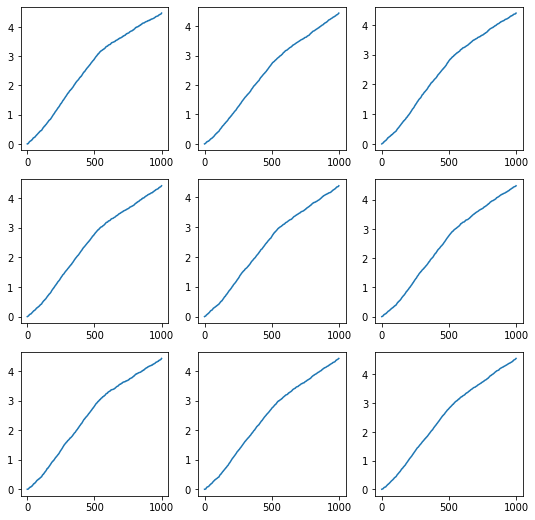

/home/pavel/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

In [7]:
""" ===================== TRAINING ======================== """


def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())


G_solver = optim.Adam(G_params, lr=LEARNING_RATE)
D_solver = optim.Adam(D_params, lr=LEARNING_RATE)

ones_label = Variable(torch.ones(BATCH_SIZE, 1))
zeros_label = Variable(torch.zeros(BATCH_SIZE, 1))

for epoch in range(NUM_EPOCHS):
    for it, signal in enumerate(dataloader):
        if signal.shape[0] != BATCH_SIZE:
            break
        # Sample data
        z = Variable(torch.randn(BATCH_SIZE, Z_dim))
        X = Variable(signal)

        # Dicriminator forward-loss-backward-update
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)

        D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
        D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake

        D_loss.backward()
        D_solver.step()

        # Housekeeping - reset gradient
        reset_grad()

        # Generator forward-loss-backward-update
        z = Variable(torch.randn(BATCH_SIZE, Z_dim))
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = nn.binary_cross_entropy(D_fake, ones_label) #+ 10*torch.norm(G_sample - torch.tensor(sample))

        G_loss.backward()
        G_solver.step()

        # Housekeeping - reset gradient
        reset_grad()

        # Print and plot every now and then
    if epoch % PRINT_EACH == 0:
        print('epoch-{}; D_loss: {}; G_loss: {}'.format(epoch, D_loss.data.numpy(), G_loss.data.numpy()))
#         print(G(z))
        samples = G(z).data.numpy()[:9]
        f, ax = plt.subplots(3, 3, figsize=(9, 9))

        for i, sample in enumerate(samples):
            ax[i//3][i%3].plot(np.cumsum(sample)/100)
#             plt.plot(sample)

        plt.show()
#             plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

#         if not os.path.exists('out/'):
#             os.makedirs('out/')

#         plt.savefig('out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
#         c += 1
#         plt.close(fig)

In [8]:
D_fake.shape

torch.Size([128, 1])

In [9]:
D_fake.shape

torch.Size([128, 1])

In [10]:
G_sample.shape

torch.Size([128, 1000])

In [11]:
G_sample[0]

tensor([1.0835e-02, 1.4527e-02, 3.2246e-02, 7.2915e-03, 7.3774e-03, 7.1891e-03,
        5.8252e-03, 8.3933e-03, 3.2497e-02, 1.2320e-02, 1.8682e-02, 1.9270e-02,
        4.8007e-02, 2.2582e-02, 3.1214e-03, 4.0444e-03, 4.5382e-02, 1.2481e-02,
        2.6645e-02, 4.4672e-03, 1.8955e-02, 1.9254e-02, 2.1914e-02, 1.4213e-02,
        6.9445e-03, 1.2401e-01, 2.5100e-02, 1.7967e-02, 7.0456e-03, 3.2848e-03,
        1.9723e-02, 7.9314e-02, 1.0575e-02, 1.0074e-03, 1.4665e-02, 5.7031e-03,
        8.3722e-02, 9.3847e-01, 3.6746e-02, 4.3743e-01, 2.1550e-02, 7.1836e-03,
        4.3226e-01, 1.9519e-02, 2.0543e-02, 1.3105e-02, 6.4611e-02, 6.2449e-01,
        1.4274e-01, 9.4208e-02, 3.8763e-02, 1.9512e-02, 6.3717e-01, 3.0728e-01,
        7.5607e-02, 5.9845e-02, 1.0815e-01, 3.0885e-02, 7.6611e-01, 4.9463e-01,
        6.3656e-01, 3.7060e-02, 1.3539e-01, 8.8316e-01, 1.9196e-01, 1.7789e-02,
        4.6481e-02, 2.5123e-01, 4.4950e-01, 6.0125e-01, 8.4269e-01, 6.3133e-02,
        9.6447e-01, 6.5957e-01, 2.7928e-

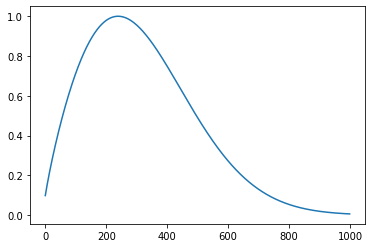

In [17]:
plt.plot(sample)

tensor([ 9.4268e-02,  1.0608e-01, -5.0623e-02, -3.6931e-01,  1.3447e-01,
         1.3675e-01,  1.4916e-01,  1.5954e-01,  1.2583e-01,  1.7463e-01,
         1.7967e-01,  1.9288e-01,  1.5480e-01,  2.0533e-01,  2.1074e-01,
         2.2279e-01, -2.3559e-01,  2.3796e-01,  2.3968e-01,  2.3286e-01,
         2.4137e-01,  1.9026e-01,  2.7025e-01,  2.6916e-01,  2.8425e-01,
         2.9646e-01, -8.1460e-02,  3.0600e-01,  3.1352e-01,  3.2148e-01,
         9.5303e-02,  3.3354e-01,  3.4392e-01,  3.5029e-01,  3.5753e-01,
         3.6442e-01,  3.7146e-01,  3.5475e-01,  3.4005e-01,  3.7944e-01,
        -5.0055e-01,  1.7240e-01,  4.0151e-01,  4.1323e-01, -5.7490e-01,
         4.2722e-01,  4.2474e-01,  4.1902e-01,  4.3368e-01, -5.2985e-01,
        -5.1172e-01, -4.8777e-01,  4.6001e-01, -4.7575e-03, -3.0882e-01,
         3.6188e-01,  3.8805e-01, -2.9838e-01,  4.8176e-01,  5.1015e-01,
         5.0396e-01,  1.8357e-01,  5.1547e-01,  5.2953e-01,  5.2755e-01,
        -3.6511e-01, -4.3841e-01,  4.2158e-01,  4.5

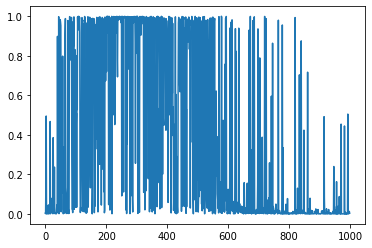

In [15]:
plt.plot(G_sample[0].detach().numpy())

In [13]:
G_sample[0]

tensor([3.8801e-03, 1.4749e-03, 1.6737e-01, 4.9508e-01, 1.4142e-04, 6.5672e-03,
        2.7260e-03, 7.8564e-04, 4.2823e-02, 2.2468e-03, 5.3153e-03, 1.2774e-04,
        4.6141e-02, 3.4593e-03, 5.8102e-03, 1.4553e-03, 4.6744e-01, 1.4358e-03,
        7.1954e-03, 2.1423e-02, 2.0259e-02, 7.8655e-02, 5.8857e-03, 1.4139e-02,
        6.1664e-03, 1.0043e-03, 3.8593e-01, 5.4191e-03, 4.8025e-03, 3.6924e-03,
        2.3667e-01, 5.1905e-03, 1.5185e-03, 1.8073e-03, 1.1855e-03, 8.6808e-04,
        3.5870e-04, 2.3561e-02, 4.4698e-02, 1.1711e-02, 8.9806e-01, 2.3144e-01,
        8.6111e-03, 3.1254e-03, 9.9746e-01, 1.4989e-03, 1.0106e-02, 2.1908e-02,
        1.3296e-02, 9.8284e-01, 9.7068e-01, 9.5267e-01, 1.0784e-02, 4.8142e-01,
        7.9130e-01, 1.2640e-01, 1.0598e-01, 7.9813e-01, 2.3672e-02, 9.3561e-04,
        1.2737e-02, 3.3870e-01, 1.2345e-02, 3.7998e-03, 1.1250e-02, 9.0935e-01,
        9.8805e-01, 1.3344e-01, 1.0522e-01, 2.2026e-03, 5.7194e-03, 5.8392e-03,
        5.3234e-03, 1.1630e-01, 9.7812e-